Deploying a Machine Learning Model
In this lab we will deploy a computer vision model trained to detect common objects in pictures.We'll use a pretrained model called [`YOLOV3`](https://pjreddie.com/darknet/yolo/). This model is very convenient for two reasons: it runs really fast, and for object detection it yields accurate results.

The sequence of steps/tasks to complete in this lab are as follow:
1. Inspect the image data set used for object detection
2. Check the model itself
3. Deploy the model using [`fastAPI`](https://fastapi.tiangolo.com/)

## Object Detection with YOLOV3

### Inspecting the images

Let's take a look at the images that will be passed to the YOLOV3 model. This will bring insight on what type of common objects are present for detection. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset.

In [ ]:
from IPython.display import Image, display

In [ ]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

Let's try and see if the model is able to detect and classify them correctly.

For this you will be using [`cvlib`](https://www.cvlib.net/), which is a very simple but powerful library for object detection that is fueled by [`OpenCV`](https://docs.opencv.org/4.5.1/) and [`Tensorflow`](https://www.tensorflow.org/).

More concretely, we will use the [`detect_common_objects`](https://docs.cvlib.net/object_detection/) function, which takes an image formatted as a [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) and returns:

- `bbox`: list of list containing bounding box coordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```
    

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['apple', 'apple']
    ```


- `conf`: list of confidence scores for detected objects.
        Example:
        
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```
    
In the next section we will visually see these elements in action.

### Creating the detect_and_draw_box function

Before using the object detection model, we create a directory where we can store the resulting images:


In [4]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the `detect_and_draw_box` function which takes as input arguments: the **filename** of a file on the system, a **model**, and a **confidence level**. With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

You might ask yourself why does this function receive the model as an input argument? What models are there to choose from? The answer is that `detect_common_objects` uses the `yolov3` model by default.  However, there is another option available that is much tinier and requires less computational power. 

It is the `yolov3-tiny` version. As the model name indicates, this model is designed for constrained environments that cannot store big models. With this comes a natural tradeoff: the results are less accurate than the full model. However, it still works pretty well. Going forward, we recommend you stick to it since it is a lot smaller than the regular `yolov3` and downloading its pretrained weights takes less time.

The model output is a vector of probabilities for the presence of different objects on the image. The last input argument, confidence level, determines the threshold that the probability needs to surpass to report that a given object is detected on the supplied image. By default, `detect_common_objects` uses a value of 0.5 for this.

In [ ]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

In [ ]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

In [ ]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before, so one might think the model has a fair representation on how an apple looks like.

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test if  this is a valid hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.34759876132011414

Detected object: orange with confidence level of 0.32876095175743103

Detected object: apple with confidence level of 0.31244680285453796

Detected object: orange with confidence level of 0.2798606753349304

Detected object: orange with confidence level of 0.2749978303909302

Detected object: apple with confidence level of 0.2744506895542145

Detected object: orange with confidence level of 0.21419063210487366



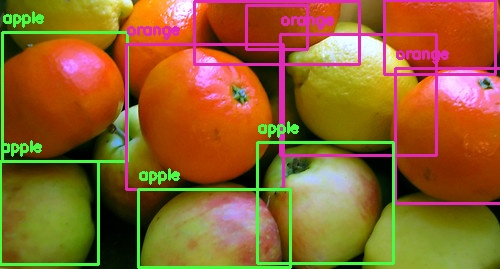

In [8]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level the model successfully detects most of the fruits. However, in order to correctly detect the objects present, we had to  set the confidence level really low. In general, you should be careful when decreasing or increasing these kinds of parameters, as changing them might yield undesired results.

As for this concrete example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

## Deploying the model using fastAPI


### Placing your object detection model in a server

Now that the model works it is time to deploy it! 
Before diving into deployment, let's quickly recap some important concepts and how they translate to `fastAPI`. Let's also create a directory to store the images that are uploaded to the server.

In [9]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Why fastAPI?

With fastAPI you can create web servers to host your models very easily. Additionally, this platform is extremely fast and it **has a built-in client that can be used to interact with the server**. 

In [10]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [11]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell the server will spin up!

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [74552]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53791 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:53791 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53793 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:53793 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:53877 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:53890 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:53948 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:54421 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:54573 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:54626 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:54628 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:54630 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:57669 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
